### CLASSIFYING ENZYMES TO FUNCTIONAL CLASSES

In [1]:
# IMPORTS - PART 1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

 * AAC - amino acid composition (frequency of each AA in a sequence) --> N x 20
 * CTD - conjoined triad descriptors () --> N x 343
 * 2-GRAM

In [2]:
# READ DATA FOR SVM, kNN and RF
aac = pd.read_csv('../dataset/aac.csv', index_col=0)
ctd = pd.read_csv('../dataset/ctd.csv', index_col=0)
data = pd.read_csv('../dataset/ngram.csv', index_col=0)
data = data.join(ctd[ctd.columns[0:-1]])
data = data.join(aac[aac.columns[0:-1]])
y = data['class']
data = data[data.columns[0:-1]]

In [3]:
# NORMALIZE DATA
mean = data.mean()
std = data.std()
data = (data-mean)/std

In [4]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(data, y)

In [5]:
# Oversample the data and divide it to train and test set
ovs = RandomOverSampler()
data_ovs, y_ovs = ovs.fit_resample(data, y)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(data_ovs, y_ovs)

In [6]:
# Accuracy and error computation (for cross validation)
def accuracy(cv_res, model_name):
    acc = np.round(np.mean(cv_res) * 100, decimals=3)
    err = np.round(np.std(cv_res) * 100, decimals=3)
    print(model_name, "has", acc, "% accuracy with", err, "% error\n(estimated with", len(cv_res), "fold cross validation)")
    return acc, err

In [7]:
# Visualize confusion matrices
def plot_cmtx(pred, y, lim=[], path=None):
    plt.rcParams["figure.figsize"] = (10, 8)
    eps1 = np.random.default_rng().uniform(low=-0.4, high=0.4, size=len(y))
    eps2 = np.random.default_rng().uniform(low=-0.4, high=0.4, size=len(y))
    plt.scatter(y+eps1, pred-eps2, c=['#53eecc' if p else '#e58b8b' for p in y==pred], alpha=0.2)
    ax = plt.gca()
    if len(lim) > 0:
        ax.set_ylim([0, 8])
    ax.set_ylabel("Predicted class", fontsize=14)
    ax.set_xlabel("True class", fontsize=14)
    gridlines = np.array(range(8)) + 0.5
    for line in gridlines:
        ax.axhline(line, linestyle='-.', alpha=0.4, color="#adadad", lw=1)
        ax.axvline(line, linestyle='-.', alpha=0.4, color="#adadad", lw=1)
    
    if path is not None:
        plt.savefig(path)

In [8]:
# Create matrices to store results
evals = pd.DataFrame(columns=['acc', 'err'])
predictions = pd.DataFrame(y_test)
predictions_ovs = pd.DataFrame(yo_test)

#### Majority Classifier

In [9]:
# DEFINE MAJORITY CLASSIFIER
class Majority_class:
    def __init__(self):
        self.major = None

    def fit(self, y):
        self.major = y.mode()
        return self
        
    def predict(self, x):
        if self.major is not None:
            return np.full(len(x), self.major)
        print('Train classifier first')

In [10]:
# CROSS VALIDATE MAJORITY CLASSIFIER
results_major = []
i = 0
j = 2400
while j <= y.size:
    test_idx = np.zeros(y.size, dtype=bool)
    test_idx[i:j] = True
    test = y[test_idx]
    train = y[np.invert(test_idx)]
    major = Majority_class()
    major = major.fit(train)
    results_major.append(np.mean(major.predict(test) == y[test_idx].to_numpy()))
    i = j
    j += 2400
    if j < y.size and y.size - j < 245:
        j = y.size

In [11]:
acc_major, err_major = accuracy(results_major, "Majority classifier")
evals.loc['MC'] = [acc_major, err_major]

Majority classifier has 33.9 % accuracy with 3.674 % error
(estimated with 10 fold cross validation)


In [12]:
pred_mc = Majority_class().fit(y_train).predict(X_test)
predictions['MC'] = pred_mc

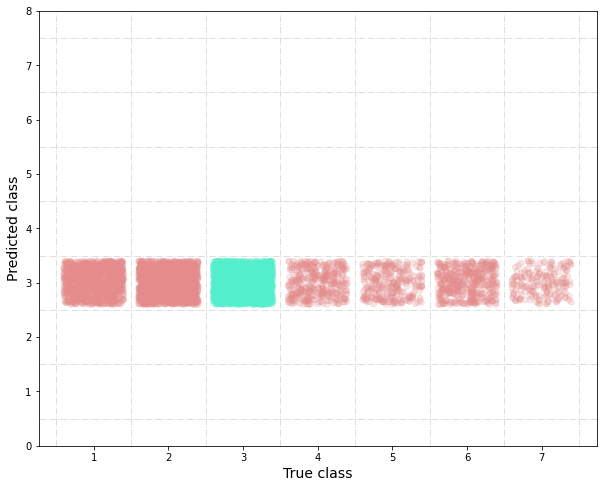

In [13]:
plot_cmtx(pred_mc, y_test, [0, 8], path="../plots/MC.png")

#### Support Vector Classifier

In [14]:
clf_svm = svm.SVC()

In [15]:
results_svm = cross_val_score(clf_svm, data, y, cv=len(results_major))

In [16]:
acc_svm, err_svm = accuracy(results_svm, "SVM classifier")
evals.loc['SVM'] = [acc_svm, err_svm]

SVM classifier has 82.359 % accuracy with 0.971 % error
(estimated with 10 fold cross validation)


In [17]:
pred_svm = clf_svm.fit(X_train, y_train).predict(X_test)
predictions['SVM'] = pred_svm

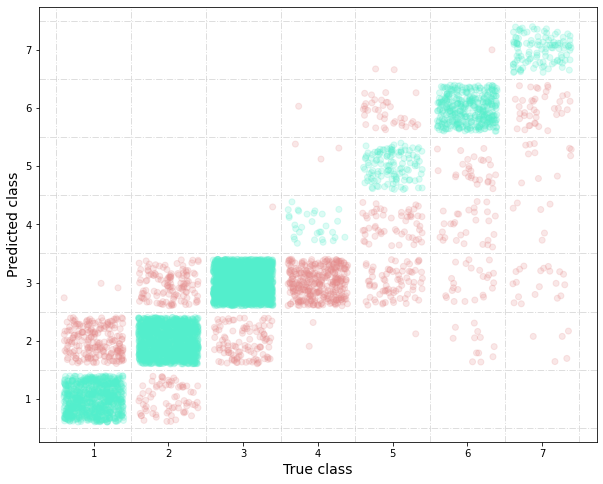

In [18]:
plot_cmtx(pred_svm, y_test, path="../plots/SVM.png")

#### SVM on oversampled data

In [19]:
results_svm_ovs = cross_val_score(clf_svm, data_ovs, y_ovs, cv=len(results_major))

In [20]:
acc_svm_o, err_svm_o = accuracy(results_svm_ovs, "Ovessampled SVM classifier")
evals.loc['SVM_o'] = [acc_svm_o, err_svm_o]

Ovessampled SVM classifier has 98.821 % accuracy with 0.464 % error
(estimated with 10 fold cross validation)


In [21]:
pred_svm_ovs = clf_svm.fit(Xo_train, yo_train).predict(Xo_test)
predictions_ovs['SVM_o'] = pred_svm_ovs

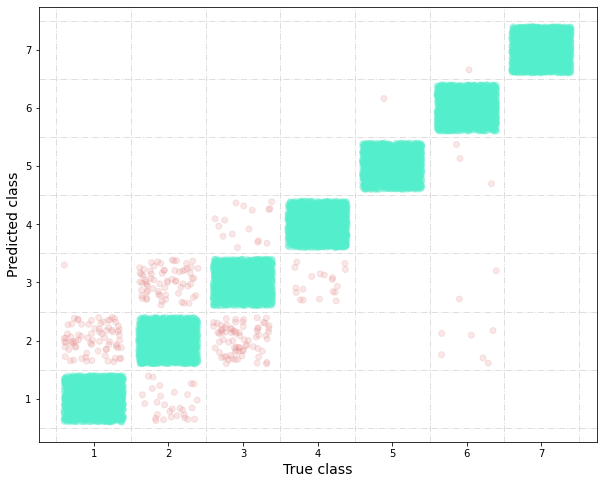

In [22]:
plot_cmtx(pred_svm_ovs, yo_test, path="../plots/ovs_SVM.png")

#### k Nearest Neighbours

In [23]:
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [24]:
results_knn = cross_val_score(clf_knn, data, y, cv=len(results_major))

In [25]:
acc_knn, err_knn = accuracy(results_knn, "kNN classifier")
evals.loc['knn'] = [acc_knn, err_knn]

kNN classifier has 40.739 % accuracy with 1.165 % error
(estimated with 10 fold cross validation)


In [26]:
pred_knn = clf_knn.fit(X_train, y_train).predict(X_test)
predictions['knn'] = pred_knn

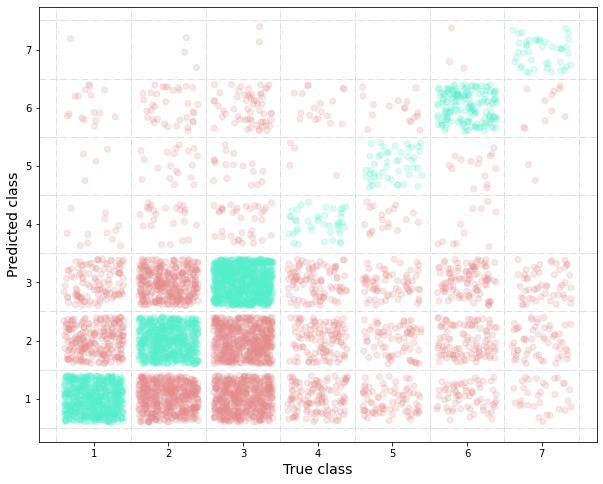

In [27]:
plot_cmtx(pred_knn, y_test, path="../plots/kNN.png")

#### kNN on oversampled data

In [28]:
results_knn_ovs = cross_val_score(clf_knn, data_ovs, y_ovs, cv=len(results_major))

In [29]:
acc_knn_o, err_knn_o = accuracy(results_knn_ovs, "Ovessampled kNN classifier")
evals.loc['knn_o'] = [acc_knn_o, err_knn_o]

Ovessampled kNN classifier has 71.621 % accuracy with 2.145 % error
(estimated with 10 fold cross validation)


In [30]:
pred_knn_ovs = clf_knn.fit(Xo_train, yo_train).predict(Xo_test)
predictions_ovs['knn_o'] = pred_knn_ovs

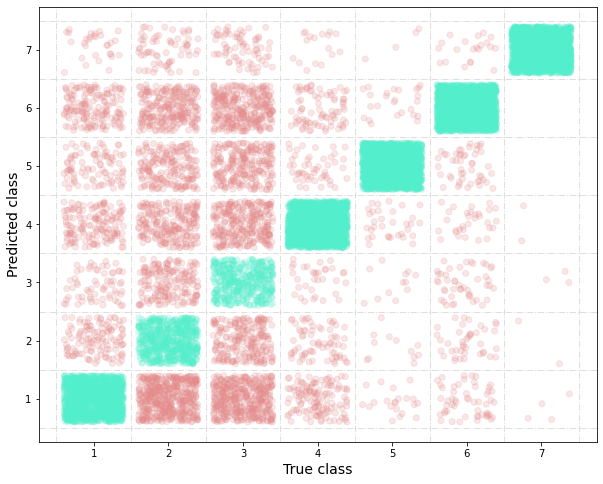

In [31]:
plot_cmtx(pred_knn_ovs, yo_test, path="../plots/ovs_kNN.png")

#### Random Forest

In [32]:
clf_rf = RandomForestClassifier()

In [33]:
results_rf = cross_val_score(clf_rf, data, y, cv=len(results_major))

In [34]:
acc_rf, err_rf = accuracy(results_rf, "Random forest classifier")
evals.loc['rf'] = [acc_rf, err_rf]

Random forest classifier has 76.075 % accuracy with 0.845 % error
(estimated with 10 fold cross validation)


In [35]:
pred_rf = clf_rf.fit(X_train, y_train).predict(X_test)
predictions['rf'] = pred_rf

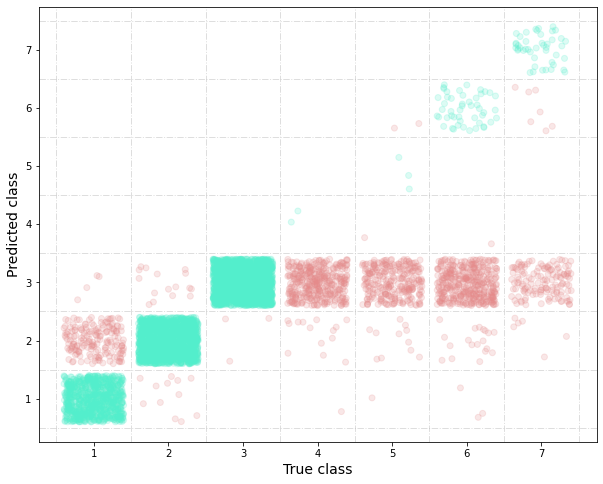

In [36]:
plot_cmtx(pred_rf, y_test, path="../plots/RF.png")

#### Random forest on oversampled data

In [37]:
results_rf_ovs = cross_val_score(clf_rf, data_ovs, y_ovs, cv=len(results_major))

In [38]:
acc_rf_o, err_rf_o = accuracy(results_rf_ovs, "Ovessampled random forest classifier")
evals.loc['rf_o'] = [acc_rf_o, err_rf_o]

Ovessampled random forest classifier has 97.435 % accuracy with 1.055 % error
(estimated with 10 fold cross validation)


In [39]:
pred_rf_ovs = clf_rf.fit(Xo_train, yo_train).predict(Xo_test)
predictions_ovs['rf_o'] = pred_rf_ovs

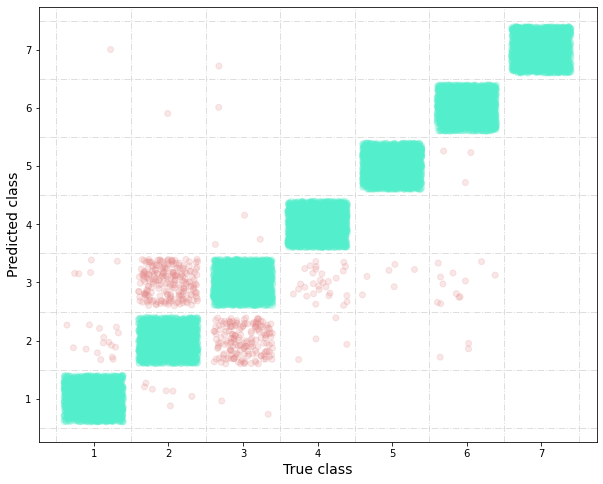

In [40]:
plot_cmtx(pred_rf_ovs, yo_test, path="../plots/ovs_RF.png")

In [41]:
# Write results to file
evals.to_csv('../eval_results/evals.csv', index=True)
predictions.to_csv('../eval_results/preds.csv', index=True)
predictions_ovs.to_csv('../eval_results/preds_ovs.csv', index=True)

In [42]:
# Some additional result-file writing (from cross-validation)
pd.DataFrame({'svm':results_svm,
             'knn':results_knn,
             'rf':results_rf}).to_csv('../eval_results/raw_cv.csv')
pd.DataFrame({'svm':results_svm_ovs,
             'knn':results_knn_ovs,
             'rf':results_rf_ovs}).to_csv('../eval_results/raw_cv_ovs.csv')

#### Neural Network

In [163]:
# IMPORTS - PART 2
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.functional import normalize, relu

from constants import path_to_bin, path_to_pssmP, path_ID, aa_order
from feature_extraction import append_truths

In [164]:
# DEFINE DATASET - consists of binary representation of AA sequence (N x 20)
#                  and PSSM matrix (N x 20)
class Enzymes(Dataset):
    def __init__(self, bin_path, pssm_path, names, transform):
        super().__init__()
        self.bin_path = bin_path
        self.pssm_path = pssm_path
        self.names = names
        self.transform = transform
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        bin_name = os.path.join(self.bin_path, names[idx])
        pssm_name = os.path.join(self.pssm_path, names[idx])
        bin_im = np.loadtxt(bin_name)
        pssm_im = np.loadtxt(pssm_name)
        sample = {'bin': bin_im, 'pssm': pssm_im}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        

In [165]:
# DEFINE TRANSFORMATION - such that binary and PSSM will act as color channels
class ToTensors():
    
    def shuffle(self, x):
        return x[:, aa_order]
    
    def __call__(self, sample):
        bin_im, pssm_im = sample['bin'], sample['pssm']
        bin_im = self.shuffle(bin_im).transpose((1, 0))
        pssm_im = self.shuffle(pssm_im).transpose((1, 0))
        
        return {'bin': normalize(torch.tensor([bin_im], dtype=torch.float32)),
               'pssm': normalize(torch.tensor([pssm_im], dtype=torch.float32))}
        

In [166]:
# READ FILE WITH FILE NAMES (enzyme ID codes)
with open(path_ID) as handle:
    names = [name.strip() for name in handle.readlines()]

In [167]:
# CREATE DATASET
data_cnn = Enzymes(path_to_bin, path_to_pssmP, names, transform=ToTensors())

# GROUND TRUTH
labels = pd.get_dummies(append_truths(pd.DataFrame(index=[name.split('.')[0] for name in names]))).to_numpy()

In [168]:
# DEFINE NEURAL NETWORK
class Neural(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2)
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.conv3 = nn.Conv2d(1, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        
        self.pool = nn.MaxPool2d(3, 2)
        self.full_con1 = nn.Linear(1536, 768)
        self.full_con2 = nn.Linear(768, 384)
        self.full_con3 = nn.Linear(1536, 768)
        self.full_con4 = nn.Linear(768, 384)
        self.full_last = nn.Linear(768, 7)
        
    def extract_bin(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        x, h = nn.LSTM(x.size()[-1], 8, 2)(x)
        x = torch.flatten(x, 0)
        x = relu(self.full_con1(x))
        x = relu(self.full_con2(x))
        return x
    
    def extract_pssm(self, x):
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        
        x, h = nn.LSTM(x.size()[-1], 8, 2)(x)
        x = torch.flatten(x, 0)
        x = relu(self.full_con3(x))
        x = relu(self.full_con4(x))
        return x
        
    def forward(self, x):
        x1 = self.extract_bin(x['bin'])
        x2 = self.extract_pssm(x['pssm'])
        x = torch.cat((x1, x2))
        x = self.full_last(x)
        return x
    
net = Neural()

In [197]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def epoch(data, labels, test, labels_test):
    running_loss = 0.0
    res_labels = []
    for i, data in enumerate(zip(data, labels)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data
        res_labels.append(np.argmax(label)+1)

        # forward + backward + optimize
        net.zero_grad(set_to_none=True)
        outputs = net(inputs)
        loss = criterion(outputs, torch.tensor(label, dtype=torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print([i + 1], 'loss:', np.round(running_loss / 2000, decimals=3))
            running_loss = 0.0

    print('Finished Training, begin testing')
    
    res = []
    for i, x in enumerate(test):
        x = np.argmax(softmax(net(x).detach().numpy())) + 1
        res.append(x)
    return res_labels, res

In [212]:
folds = KFold(n_splits=5)
results = []
res_labels = []
for fold, (train, test) in enumerate(folds.split(names)):
    print('Running fold:', fold+1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.002)
    
    data_train = Subset(data_cnn, train)
    label_train = Subset(labels, train)
    data_test = Subset(data_cnn, test)
    label_test = Subset(labels, test)
    res_label, res = epoch(data_train.dataset, label_train.dataset, data_test.dataset, label_test.dataset)
    results.append(res)
    res_labels.append(res_label)

Running fold: 1
[2000] loss: 6.533
[4000] loss: 4.667
[6000] loss: 3.998
[8000] loss: 4.853
[10000] loss: 6.936
[12000] loss: 3.881
[14000] loss: 5.347
[16000] loss: 4.462
[18000] loss: 4.194
[20000] loss: 4.697
Finished Training, begin testing
Running fold: 2
[2000] loss: 6.387
[4000] loss: 7.89
[6000] loss: 5.807
[8000] loss: 5.658
[10000] loss: 7.12
[12000] loss: 4.393
[14000] loss: 3.958
[16000] loss: 4.506
[18000] loss: 10.782
[20000] loss: 4.824
Finished Training, begin testing
Running fold: 3
[2000] loss: 5.571
[4000] loss: 6.605
[6000] loss: 5.084
[8000] loss: 6.837
[10000] loss: 4.735
[12000] loss: 4.79
[14000] loss: 4.551
[16000] loss: 4.217
[18000] loss: 3.874
[20000] loss: 4.417
Finished Training, begin testing
Running fold: 4
[2000] loss: 7.034
[4000] loss: 6.53
[6000] loss: 4.35
[8000] loss: 4.625
[10000] loss: 4.88
[12000] loss: 4.362
[14000] loss: 4.394
[16000] loss: 4.535
[18000] loss: 4.355
[20000] loss: 4.033
Finished Training, begin testing
Running fold: 5
[2000] lo

In [171]:
torch.save(net.state_dict(), './model_cnn.pth')

In [121]:
true = np.argmax(labels[18001:], axis=1) + 1
b = pd.Series(true, index=names[18001:]) == pd.Series(res, index=names[18001:])
print(np.round(b.mean()*100, decimals=3))

44.805


In [235]:
pd.DataFrame(results).to_csv('../eval_results/NN.csv')
pd.DataFrame(res_labels).to_csv('../eval_results/NN_labels.csv')

In [223]:
accs = [np.mean(np.array(l) == np.array(r)) for l, r in zip(res_labels, results)]

In [226]:
acc_cnn, err_cnn = accuracy(accs, 'NN')

NN has 31.05 % accuracy with 6.92 % error
(estimated with 5 fold cross validation)


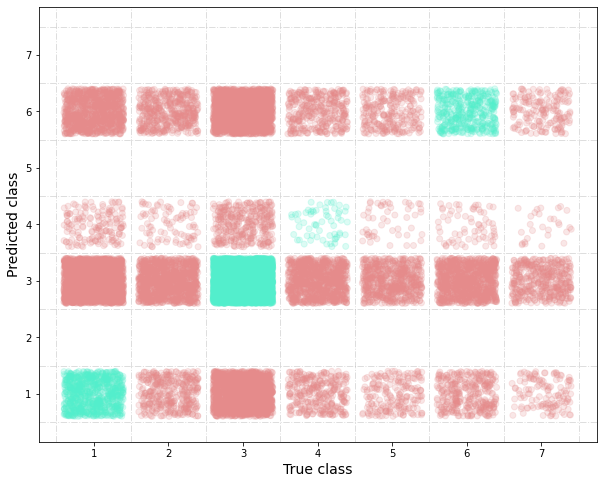

In [236]:
plot_cmtx(np.array(results[1]), np.array(res_labels[4]), path="../plots/NN.png")

In [292]:
acc_all = {'Mayority classifier': acc_major, 
           'SVM': acc_svm, 
           'SVM (oversampled)': acc_svm_o, 
           'kNN': acc_knn, 
           'kNN (oversampled)': acc_knn_o, 
           'RF': acc_rf, 
           'RF (oversampled)': acc_rf_o, 
           'Neural network': acc_cnn}
err_all = {'Mayority classifier': err_major, 
           'SVM': err_svm, 
           'SVM (oversampled)': err_svm_o, 
           'kNN': err_knn, 
           'kNN (oversampled)': err_knn_o, 
           'RF': err_rf, 
           'RF (oversampled)': err_rf_o, 
           'Neural network': err_cnn}

final = [(k, acc_all[k], err_all[k]) for k in acc_all.keys()]

In [333]:
def create_table(data, cols, scl, cw=None, path=None):
    if cw is None:
        cw = [1/len(cols) for c in cols]
    tbl = plt.table(data,
             loc='center',
             cellLoc='center',
             colLabels=cols,
             colLoc='center',
             colColours=['#fde9c2' for c in cols],
             colWidths = cw)
    tbl.set_fontsize(15)
    tbl.scale(scl[0], scl[1])
    plt.axis('off')
    if path is not None:
        plt.savefig(path)

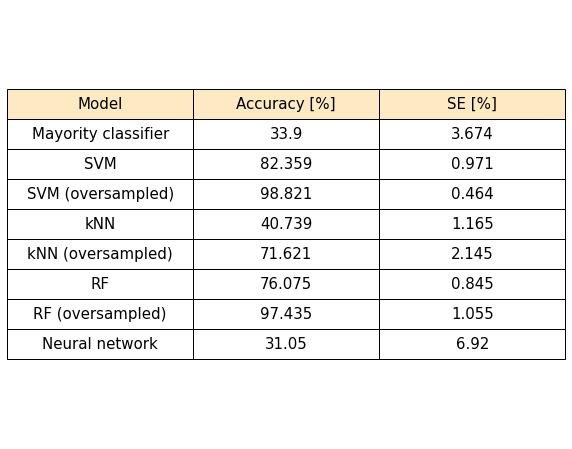

In [334]:
create_table(final, ['Model', 'Accuracy [%]', 'SE [%]'], [1, 2.5], path="../plots/models_evaluated.png")

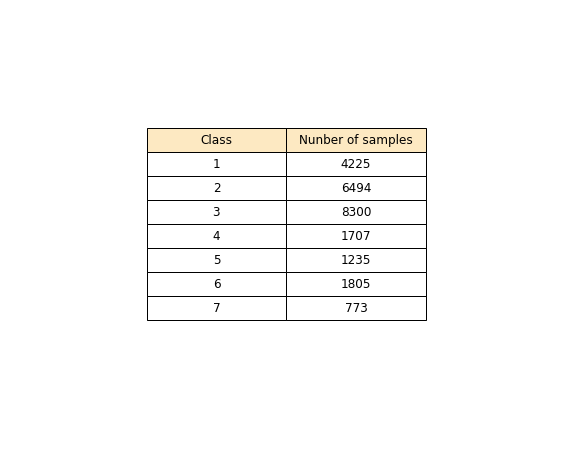

In [319]:
from collections import Counter
counts = Counter(y)
create_table([(k, counts[k]) for k in range(1, 8)], ['Class', 'Nunber of samples'], [0.5, 2], path="../plots/by_classes.png")

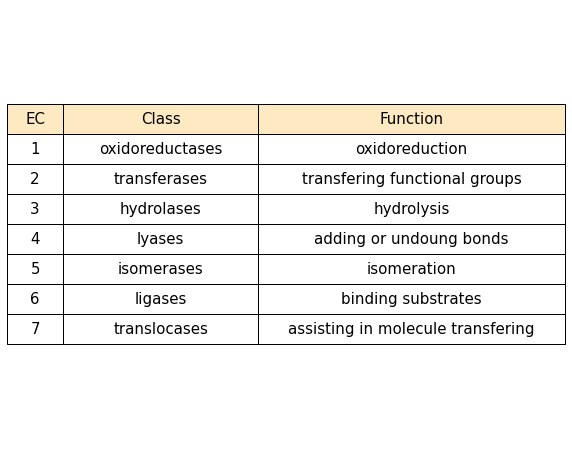

In [335]:
info = [(1, 'oxidoreductases', 'oxidoreduction'),
        (2, 'transferases', 'transfering functional groups'),
        (3, 'hydrolases', 'hydrolysis'),
        (4, 'lyases', 'adding or undoung bonds'),
        (5, 'isomerases', 'isomeration'),
        (6, 'ligases', 'binding substrates'),
        (7, 'translocases', 'assisting in molecule transfering')]
create_table(info, ['EC', 'Class', 'Function'], [1, 2.5], cw=[0.1, 0.35, 0.55], path="../plots/functions.png")